## **Fig3a,b,h** ##

In [1]:
# 2025.10.19 Select genes to be shown

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from critical_bandwidth import critical_bandwidth,critical_bandwidth_m_modes

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema

import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

from scipy.integrate import quad
from scipy.stats import norm

import scanpy as sc
import seaborn as sns


from scipy.spatial.distance import cdist

def find_nearest_indices(average_path, X_umap, k=50):
    """
    找到X_umap中距离average_path每个点最近的k个点的索引
    
    参数:
    average_path : np.ndarray, shape (n, d)
        路径点数组
    X_umap : np.ndarray, shape (m, d)
        待搜索的点集
    k : int, 默认50
        要找到的最近邻数量
    
    返回:
    cell_arr : list of lists
        每个元素是一个包含最近邻索引的列表
    """
    # 计算所有点对之间的距离矩阵
    distances = cdist(average_path, X_umap, 'euclidean')
    
    # 对每一行(即每个average_path点)的距离进行排序，获取前k个最小距离的索引
    nearest_indices = np.argsort(distances, axis=1)[:, :k]
    
    # 转换为列表的列表
    cell_arr = [row.tolist() for row in nearest_indices]
    
    return cell_arr

In [2]:
data_name = 'zebrafish_dynamo_part'
[k_nei, K, L] = [10,3,6]
adata = sc.read('data/'+data_name+'.h5ad')


path_name1 = 'zebrafish_dynamo_part_P2M'
path_path1 = 'FI_distribution_rc/'+path_name1+'/'
mean_FIMs1 = np.load(path_path1+'mean_FIMs.npy')

path_name2 = 'zebrafish_dynamo_part_P2S'
path_path2 = 'FI_distribution_rc/'+path_name2+'/'
mean_FIMs2 = np.load(path_path2+'mean_FIMs.npy')

path_name3 = 'zebrafish_dynamo_part_P2X'
path_path3 = 'FI_distribution_rc/'+path_name3+'/'
mean_FIMs3 = np.load(path_path3+'mean_FIMs.npy')

result_path = 'dotplot2/'
import os
folder = os.path.exists(result_path)
if not folder:
    os.makedirs(result_path)
encoder_path = f'main_results/zebrafish_dynamo_part [{k_nei}, {K}, {L}]/'
encoder = np.load(encoder_path+'encoder.pt')

In [3]:
adata.obsm['X_pca'][1:].shape

(3385, 50)

In [4]:
from scipy.sparse import csr_matrix
from utils import *
from g2g_model_Fisher import *
import torch

sc.pp.pca(adata, n_comps=50)
sc.pp.neighbors(adata, n_neighbors=k_nei)
gene_arr = adata.var.index.values
X_pca = adata.obsm['X_pca']
X_umap = adata.obsm['X_umap']
Xs = adata.layers['Ms'] #adata.X.A#
# Xs = adata.layers['M_s'] #如果是EG_ab_dyn
X = Xs

row = np.array([np.ones((k_nei,))*i for i in range(adata.shape[0])]).flatten()
col = (adata.obsp['distances']+csr_matrix(np.eye(adata.obsp['distances'].shape[0]))).indices
w_val = np.array([np.linalg.norm(X_pca[int(i),:]-X_pca[int(j),:]) for i,j in zip(row,col)])
adj_val = np.ones(col.shape)
A_mat = csr_matrix((adj_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))
W_mat = csr_matrix((w_val, (row, col)), shape=(adata.shape[0], adata.shape[0]))

dc=np.amax(adata.obsp['distances'])
cell_nei=adata.obsp['distances'].indices.reshape([-1,k_nei-1])
nei_w=[]
rho_arr=[]
for i in range(cell_nei.shape[0]):
    dij=np.array([np.linalg.norm(X_pca[i,:]-X_pca[int(j),:]) for j in cell_nei[i]])
    
    rho=np.sum(np.exp(-dij**2/dc**2))
    nei_w.append(np.exp(-dij**2/dc**2)/rho)
    rho_arr.append(rho)
rho_arr=np.array(rho_arr)/np.amax(rho_arr)
nei_w=np.array(nei_w)


#################################################
#################################################
encoder = torch.load(encoder_path+'encoder.pt')


mu, sigma = encoder(torch.tensor(X))
mu_learned = mu.detach().numpy()
sigma_learned = sigma.detach().numpy()

Fisher_g=np.zeros((X.shape[0],L*2,L*2))
for i in range(X.shape[0]):
    for j in range(L):
        Fisher_g[i,j,j]=1/sigma_learned[i,j]**2
        Fisher_g[i,L+j,L+j]=2/sigma_learned[i,j]**2

Fisher_g_diag = np.zeros([X.shape[0],L*2])
for i in range(X.shape[0]):
    Fisher_g_diag[i] = np.diag(Fisher_g[i])

def smooth_func(X_val,cell_nei=cell_nei,nei_w=nei_w):
    X_s=X_val.copy()
    for ci in range(len(X_val)):
        X_s[ci]=np.dot(X_val[cell_nei[ci,:]],nei_w[ci,:])
    return(X_s)

def wasserstein_distance(mu1,sigma1,mu2,sigma2):
    dim=len(mu1)
    dmu=mu1-mu2
    W_dist2=0
    for i in range(dim):
        W_dist2+=dmu[i]**2+sigma1[i]**2+sigma2[i]**2-2*np.sqrt(sigma2[i]*sigma1[i]**2*sigma2[i])
    W_dist=np.sqrt(W_dist2+1e-12)
    return W_dist

cRc_arr=[]
cRc_arr_eu=[]
A = csr_matrix(A_mat + np.eye(A_mat.shape[0]))
for inds in np.split(A.indices, A.indptr)[1:-1]:
    self_ind=inds[0]
    cRc=0
    cRc_eu=0
    for nei_k in range(1,len(inds)):

        dEu=np.linalg.norm(X[self_ind,:]-X[inds[nei_k],:])
        dFi=Fisher_dist(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])
        dWa=wasserstein_distance(mu_learned[self_ind,:],sigma_learned[self_ind,:],\
                        mu_learned[inds[nei_k],:],sigma_learned[inds[nei_k],:])

        cRc+=1-dWa/dFi
        cRc_eu+=1-dWa/dEu

    cRc_arr.append(cRc/len(inds))
    cRc_arr_eu.append(cRc_eu/len(inds))
crc = np.array(cRc_arr)
crc_eu = np.array(cRc_arr_eu)
crc_smooth = smooth_func(crc_eu)

/home/sirin/anaconda3/envs/sc_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mean_FIMs = np.concatenate([mean_FIMs1,mean_FIMs2],axis=0)
mean_FIs = np.zeros([mean_FIMs.shape[0], mean_FIMs.shape[1]])
for k in range(mean_FIMs.shape[0]):
    mean_FIs[k] = np.diag(mean_FIMs[k])
mean_FIs = np.log10(mean_FIs)
mean_FIs.shape

(18, 600)

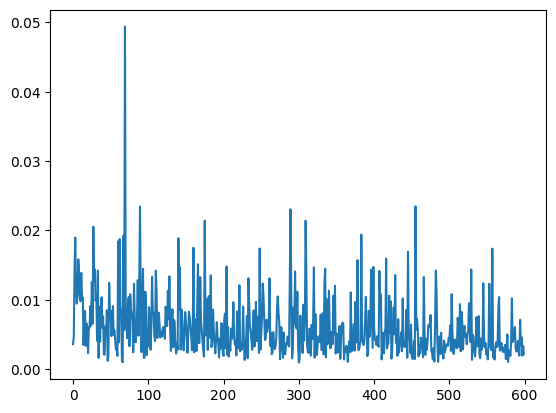

21

In [6]:
# Variation of FIs of each gene
FI_var = np.var(mean_FIs, axis=0)
FI_mean = np.mean(mean_FIs, axis=0)
FI_cv = FI_var/np.abs(FI_mean)
plt.plot(FI_cv)
plt.show()
np.sum(FI_cv>0.015)

In [7]:
average_path_P2M = np.load('zebrafish_P2M_rc.npy')
average_path_P2S = np.load('zebrafish_P2S_rc.npy')
average_path_P2X = np.load('zebrafish_P2X_rc.npy')
X_umap = adata.obsm['X_umap']

cell_arr_P2M = find_nearest_indices(average_path_P2M, X_umap, k=50)
cell_arr_P2S = find_nearest_indices(average_path_P2S, X_umap, k=50)
cell_arr_P2X = find_nearest_indices(average_path_P2X, X_umap, k=50)

In [8]:
pZ_pGE = np.zeros([X.shape[0], L*2, X.shape[1]])

# Compute the gradients
encoder.train()
for i in range(X.shape[0]):
    x0=torch.tensor(X[i,:],requires_grad=True)
    mu, sigma=encoder(x0)
    z = torch.cat([mu, sigma])
    for j in range(2*L):
        x0.grad = None    
        z[j].backward(retain_graph=True)
        pZ_pGE[i,j,:] = x0.grad.detach()

In [9]:
diagFIgene = np.zeros((X.shape[0],X.shape[1]))

for i in range(X.shape[0]):
    FIgene = pZ_pGE[i].T@Fisher_g[i]@pZ_pGE[i]
    for j in range(FIgene.shape[1]):
        diagFIgene[i,j] = FIgene[j,j]

In [10]:
# select gene with significant FI variation 
# gene_label = np.where(FI_cv>0.015)[0]
# gene_name = adata.var_names[gene_label]
# gene_label, gene_name

# select gene with largest FI
gene_label = np.argsort(FI_mean)[-20:]
gene_name = adata.var_names[gene_label]
gene_label, gene_name

(array([175,  11,  81, 160, 337,  27,  90, 369,  25, 309,  16,  50, 288,
        348, 261, 295,  19,  69,  13,  89]),
 Index(['rrm2', 'cd59', 'thy1', 's100b', 'mmp17b', 'aqp3a', 'mpz', 'mical3a',
        'tyrp1b', 'ctgfa', 'gch2', 'glula', 'tspan15', 'si:dkey-31g6.6',
        'zgc:165461', 'BX908782.3', 'wu:fc46h12', 'id2b', 'pmp22b', 'cldnk'],
       dtype='object'))

In [11]:
from matplotlib import font_manager
def PLT_frequency(matrix,title_name='Frequency Distribution with KDE Curve',label_name=None,save_path=None,b=None, ymax=None):
    L = matrix.shape[1]
    if label_name is None:
        label_name = [str(LL) for LL in range(L)]
    for LL in range(L):
        if b is None:
            bb=np.max(matrix[:,LL])
        else:
            bb=b[LL]
        data = matrix[:,LL]/bb
    # 绘制直方图和KDE曲线
        sns.kdeplot(data, linewidth=10,label=label_name[LL])
    # plt.legend(fontsize=12)
    # plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')
    # 添加标题和标签
    # plt.title(title_name,fontsize=16,weight='bold')
    plt.xlabel('Relative value',fontsize=24,weight='bold')
    plt.ylabel('Density',fontsize=24,weight='bold')
    plt.xlim(-0.1,1.1)
    if ymax:
        plt.ylim(0,ymax)

    plt.xticks(fontsize=20,fontweight='bold')
    plt.yticks(fontsize=20,fontweight='bold')

    if save_path is None:
        plt.show()
        return None
    plt.savefig(save_path,dpi=300, bbox_inches='tight')
    # 显示图表
    plt.show()

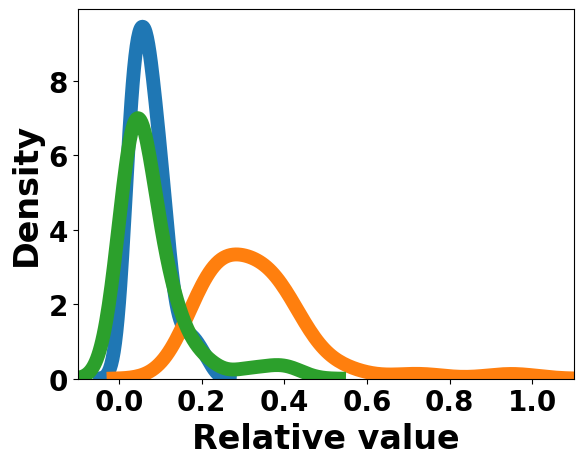

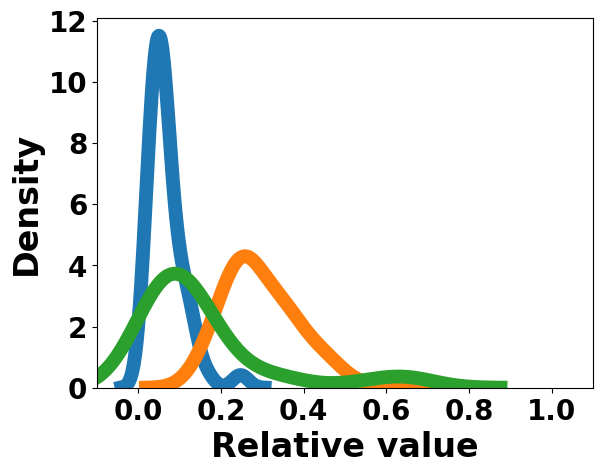

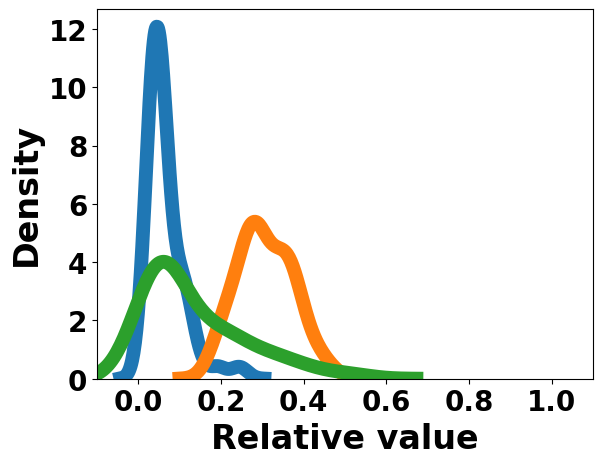

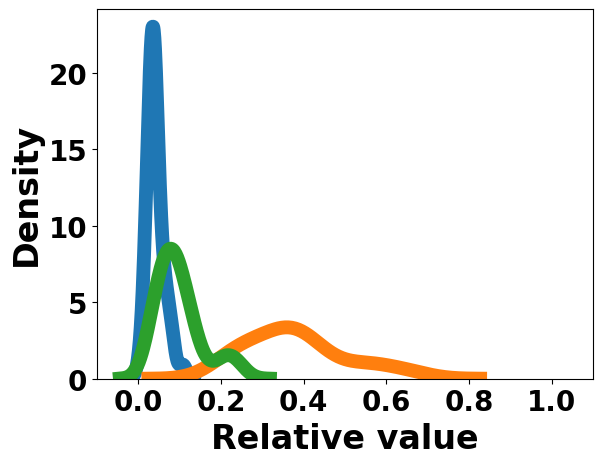

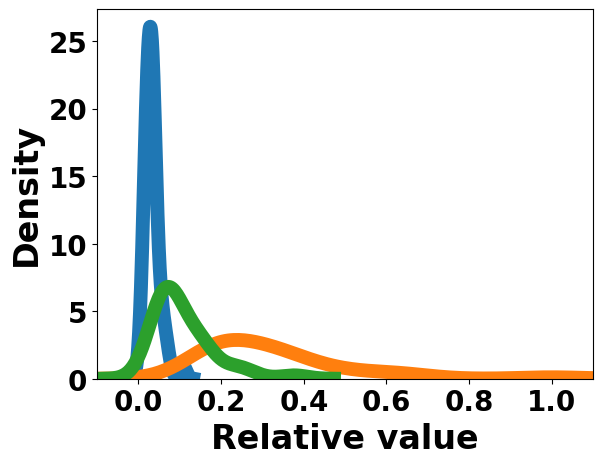

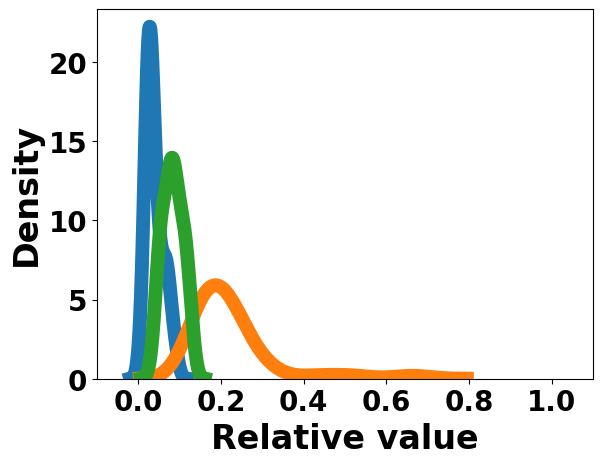

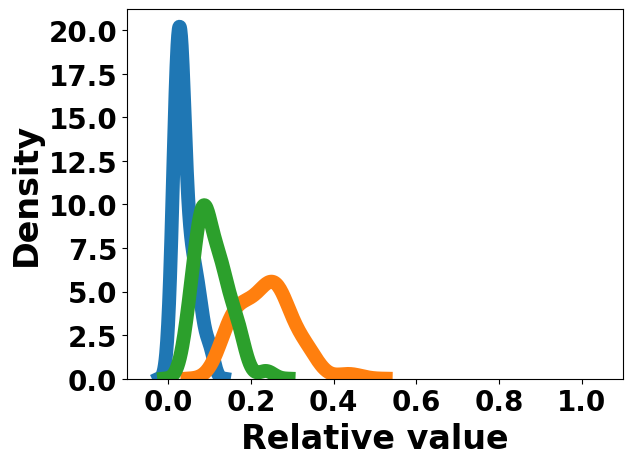

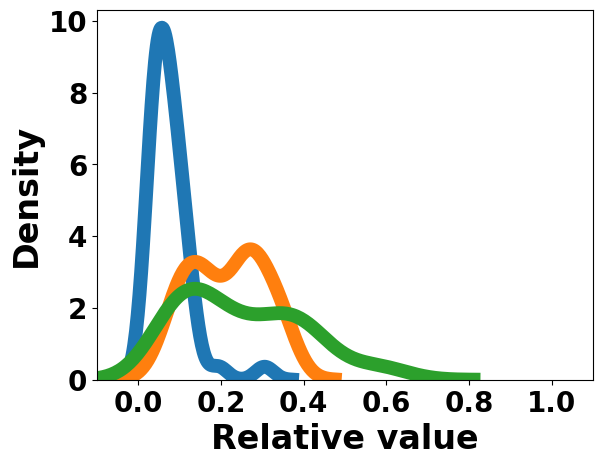

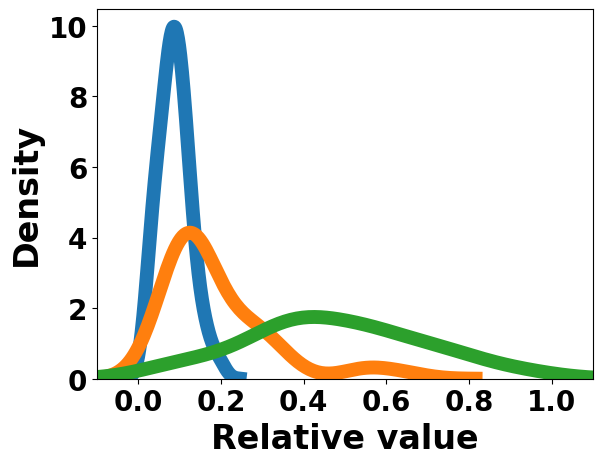

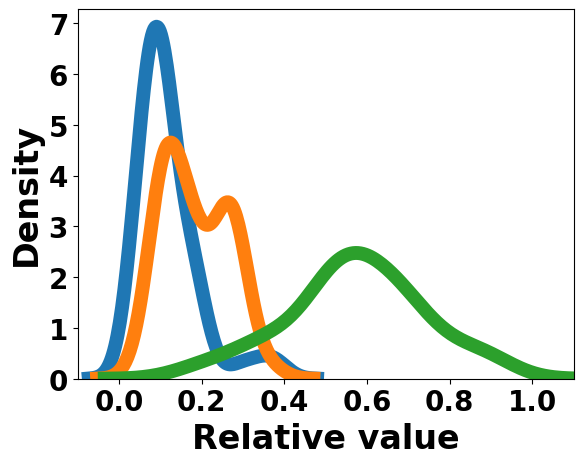

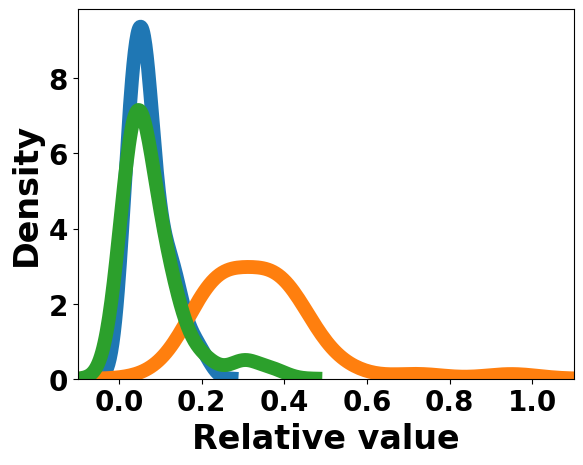

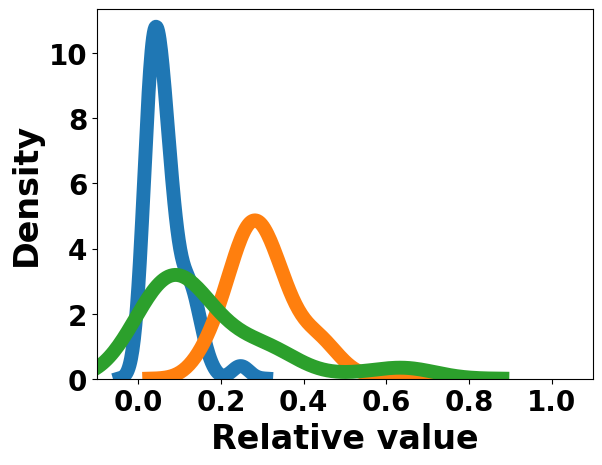

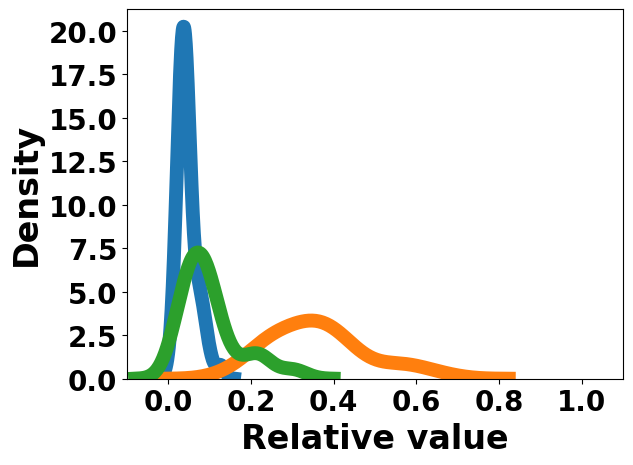

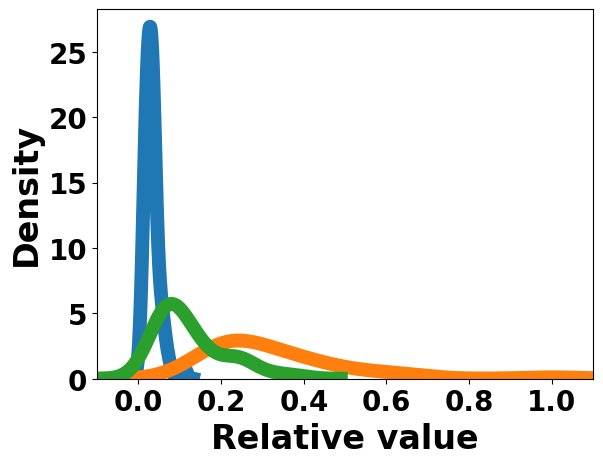

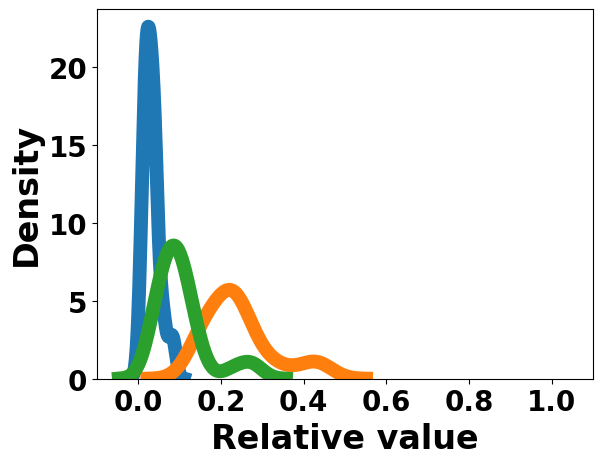

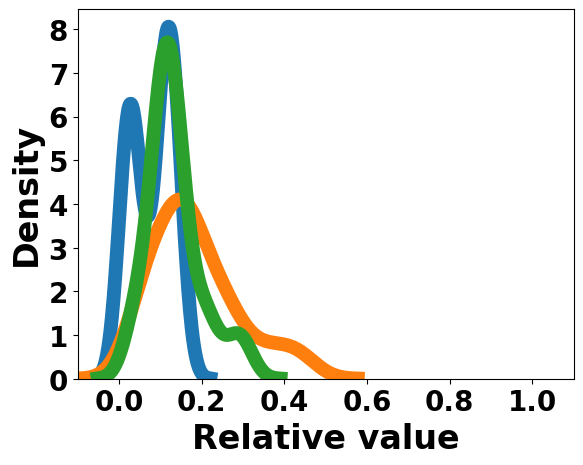

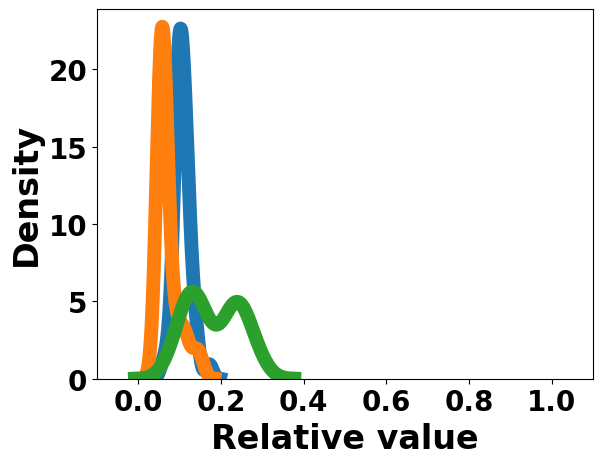

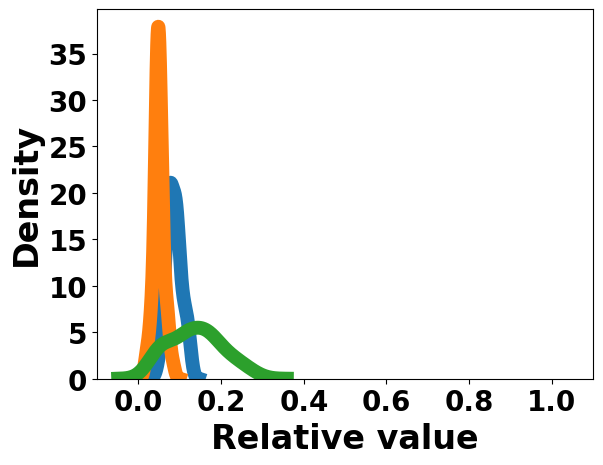

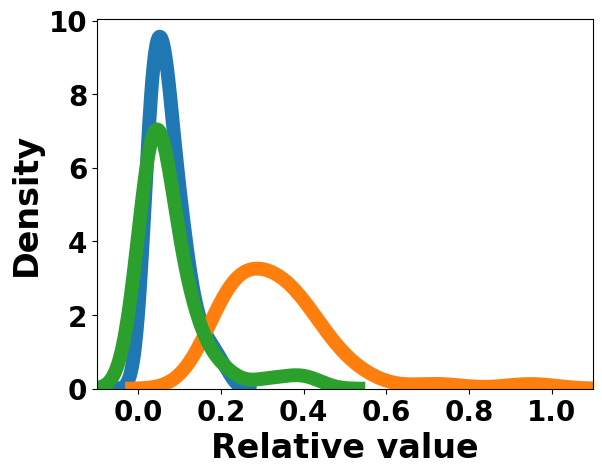

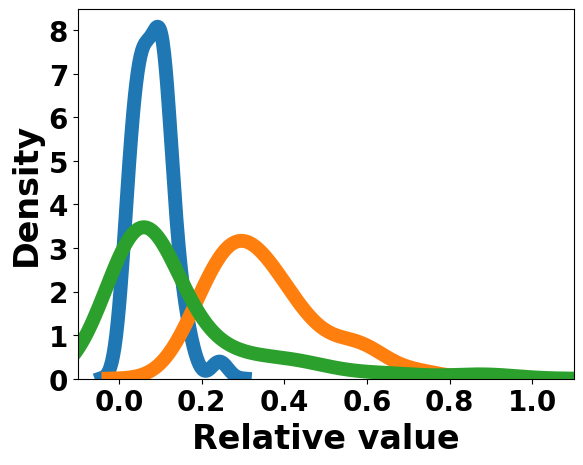

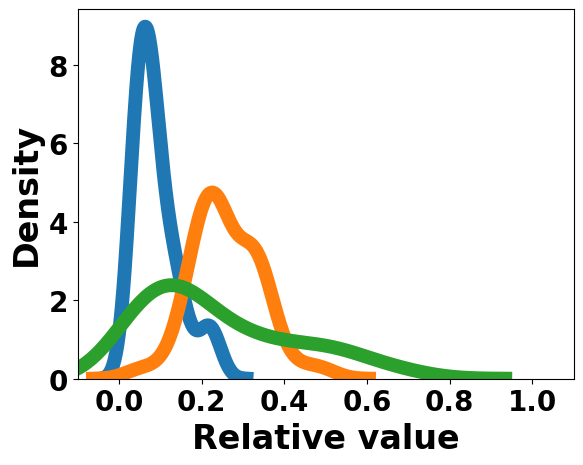

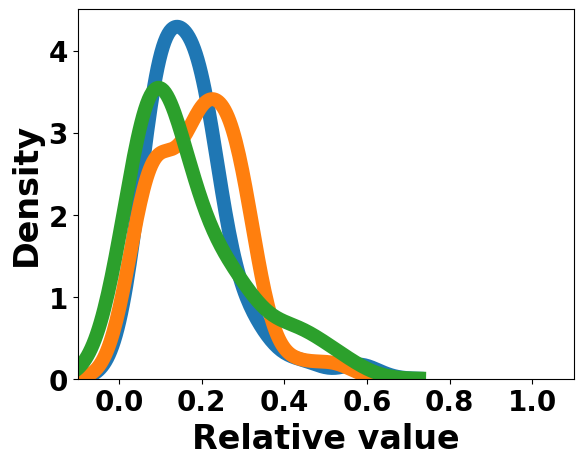

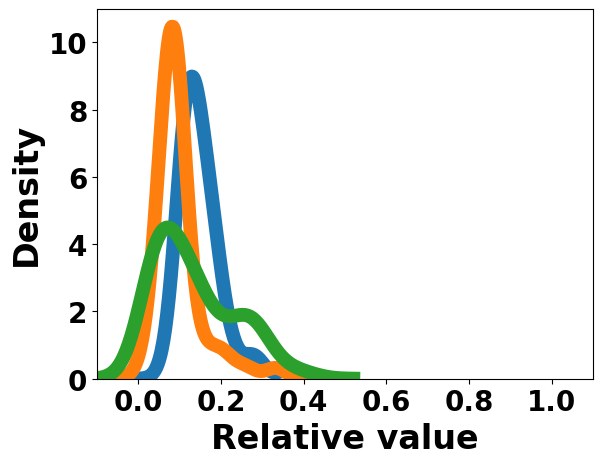

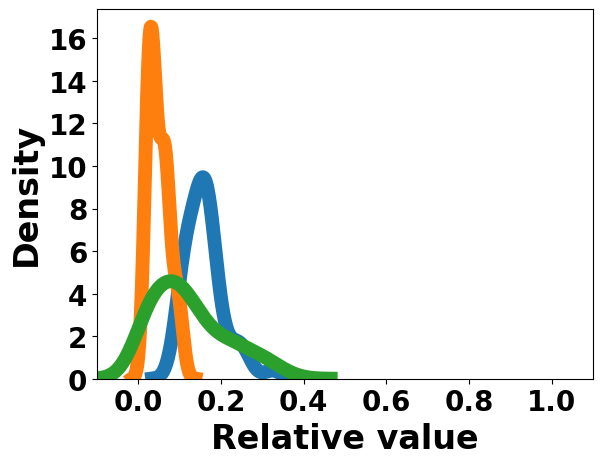

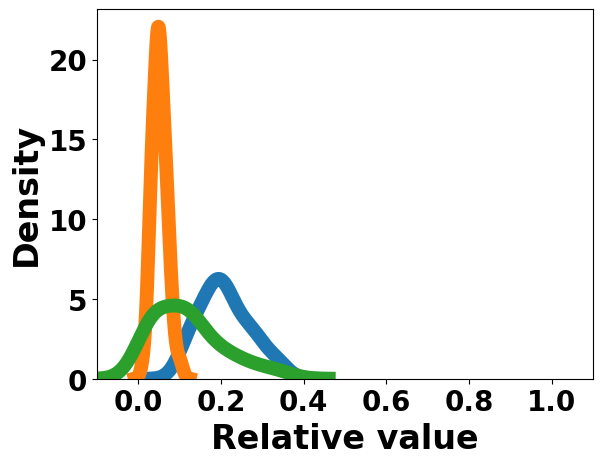

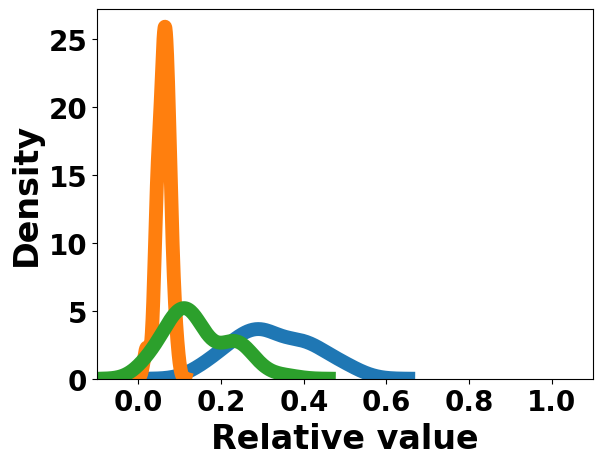

In [12]:
name_tmp = ['rrm2', 'pmp22b', 'ctgfa']
label_tmp = [175, 13, 309]
for k in range(len(cell_arr_P2M)):
    PLT_frequency(diagFIgene[np.array(cell_arr_P2M[k])][:,label_tmp],title_name=f'{k+1}',
                  label_name=name_tmp,save_path=result_path+f'P2M RC{k+1}'+'.png',b=np.max(diagFIgene[:,label_tmp],axis=0))

for k in range(len(cell_arr_P2X)):
    PLT_frequency(diagFIgene[np.array(cell_arr_P2X[k])][:,label_tmp],title_name=f'{k+1}',
                  label_name=name_tmp,save_path=result_path+f'P2X RC{k+1}'+'.png',b=np.max(diagFIgene[:,label_tmp],axis=0))

for k in range(len(cell_arr_P2S)):
    PLT_frequency(diagFIgene[np.array(cell_arr_P2S[k])][:,label_tmp],title_name=f'{k+1}',
                  label_name=name_tmp,save_path=result_path+f'P2S RC{k+1}'+'.png',b=np.max(diagFIgene[:,label_tmp],axis=0))

In [13]:
import pandas as pd
from scipy.sparse import csr_matrix,issparse

fisher_adata = adata.copy()
fisher_adata.X = diagFIgene

# ========== 1. 自定义细胞类型顺序 ==========
custom_order = ["Schwann Cell", 'Schwann Cell Precursor', 'Proliferating Progenitor', 
                'Pigment Progenitor', 'Melanophore', 'Xanthophore']

# 强制排序并过滤 Other glia
fisher_adata.obs["Cell_type"] = (
    fisher_adata.obs["Cell_type"]
    .astype("category")
    .cat.set_categories(custom_order)
    .cat.remove_unused_categories()
)

# ========== 2. 按 Melanophore 表达量排序基因 ==========
# 提取 Melanophore 细胞的表达数据
expression_data = fisher_adata[fisher_adata.obs["Cell_type"] == "Melanophore", gene_name].X
if issparse(expression_data):
    expression_data = expression_data.toarray()



# 计算基因在 Melanophore 中的平均表达量（降序排序）
gene_order_melanophore = pd.DataFrame(expression_data, columns=gene_name).mean(axis=0)
gene_order_melanophore = gene_order_melanophore.sort_values(ascending=False).index.tolist()

# ========== 3. 计算 CV 并确保顺序一致 ==========
# 确保 expr_df 的 Cell_type 已被正确过滤
expr_df = pd.DataFrame(
    fisher_adata[:, gene_name].X.toarray() if issparse(fisher_adata.X) else fisher_adata[:, gene_name].X,
    columns=gene_name,
    index=fisher_adata.obs.index
)
expr_df["Cell_type"] = fisher_adata.obs["Cell_type"]

# 计算 CV，并按 custom_order 和 gene_order_melanophore 对齐顺序
cv_df = (
    expr_df.groupby("Cell_type")
    .apply(lambda g: g.std() / g.mean().replace(0, np.nan))
    .fillna(0)
    .loc[custom_order, gene_name]  # 关键：按自定义顺序对齐行和列
)

/tmp/ipykernel_1427/3292721267.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_df.groupby("Cell_type")


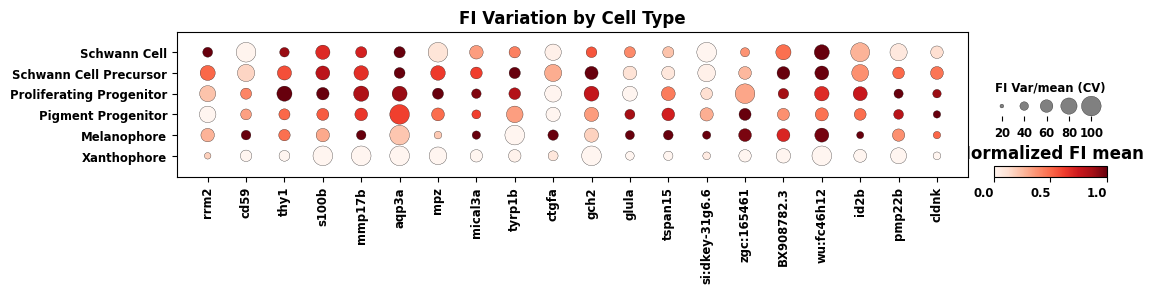

In [14]:
# ========== 4. 绘图（应用排序） ==========
sc.pl.dotplot(
    fisher_adata,
    groupby="Cell_type",
    var_names=gene_name,  # 确保基因顺序应用
    categories_order=custom_order,
    dot_size_df=cv_df,
    standard_scale="var",
    size_title="FI Var/mean (CV)",
    colorbar_title='Normalized FI mean',
    title="FI Variation by Cell Type",
    show=False,
    figsize=(12, 2.5),
    dot_max=1,      # 最大点大小比例 (0-1)
    dot_min=0.1       # 最小点大小比例 (0-1)
)

# ========== 手动设置所有字体加粗 ==========
# 获取当前图形的所有元素并设置为加粗
fig = plt.gcf()
ax = plt.gca()

# 设置标题加粗
ax.set_title(ax.get_title(), fontweight='bold')

# 设置x轴和y轴标签加粗
ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
ax.set_ylabel(ax.get_ylabel(), fontweight='bold')

# 设置x轴和y轴刻度标签加粗
for label in ax.get_xticklabels():
    label.set_fontweight('bold')


for label in ax.get_yticklabels():
    label.set_fontweight('bold')


# 设置图例标题和标签加粗（如果有的话）
legend = ax.get_legend()
if legend:
    legend.set_title(legend.get_title().get_text(), prop={'weight': 'bold'})
    for text in legend.get_texts():
        text.set_fontweight('bold')

# 设置colorbar标题和刻度标签加粗
for child in fig.get_children():
    if hasattr(child, 'get_axes'):
        for sub_ax in child.get_axes():
            # colorbar轴
            if hasattr(sub_ax, 'get_ylabel') and sub_ax.get_ylabel():
                sub_ax.set_ylabel(sub_ax.get_ylabel(), fontweight='bold')
            
            # colorbar刻度标签
            for label in sub_ax.get_yticklabels():
                label.set_fontweight('bold')
                
            for label in sub_ax.get_xticklabels():
                label.set_fontweight('bold')
                

# 查找并设置colorbar标题加粗（scanpy特有的colorbar处理）
for child in fig.get_children():
    if hasattr(child, 'colorbar'):
        cb = child.colorbar
        if hasattr(cb, 'set_label'):
            cb.set_label(cb.get_label(), fontweight='bold')

# 另一种方法：直接查找所有text对象并设置加粗
for text in fig.findobj(plt.Text):
    if text.get_text():  # 只处理非空文本
        text.set_fontweight('bold')

# ========== 调整布局和保存 ==========
plt.gcf().subplots_adjust(bottom=0.3)
plt.xticks(ha='right', fontweight='bold')
plt.yticks(fontweight='bold')

plt.savefig(
    result_path + 'dotplot_final_bold.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.savefig(
    result_path + 'dotplot_final.png',
    dpi=300,
    bbox_inches='tight',       # 自动计算最佳边界
    facecolor='white'
)
plt.show()

In [15]:
V = ['cd59','ctgfa','si:dkey-31g6.6','glula','tspan15','zgc:165461','id2b','cldnk','mical3a','mmp17b','pmp22b','thy1','s100b','mpz','tyrp1b','gch2','BX908782.3','aqp3a','wu:fc46h12','rrm2']

/tmp/ipykernel_1427/2872919608.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  expr_df.groupby("Cell_type")


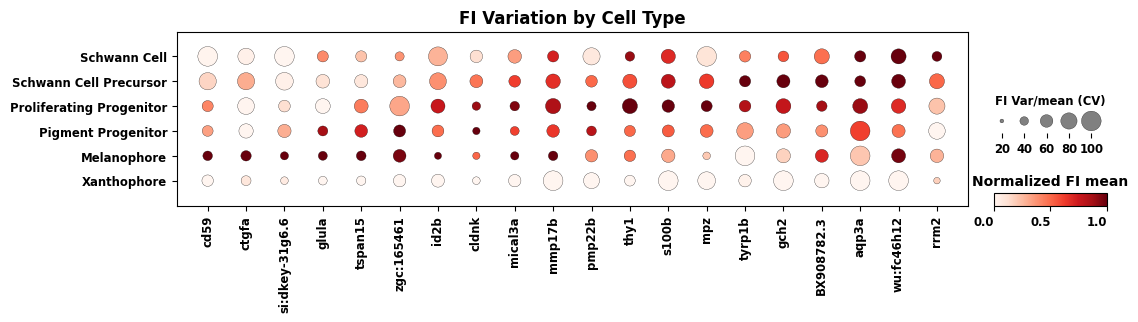

In [16]:
cv_df = (
    expr_df.groupby("Cell_type")
    .apply(lambda g: g.std() / g.mean().replace(0, np.nan))
    .fillna(0)
    .loc[custom_order, V]  # 列按 Schwann Cell 表达升序排列
)
# ========== 4. 绘图（应用排序） ==========
sc.pl.dotplot(
    fisher_adata,
    groupby="Cell_type",
    var_names=V,  # 确保基因顺序应用
    categories_order=custom_order,
    dot_size_df=cv_df,
    standard_scale="var",
    size_title="FI Var/mean (CV)",
    colorbar_title='Normalized FI mean',
    title="FI Variation by Cell Type",
    show=False,
    figsize=(12, 3),
    dot_max=1,      # 最大点大小比例 (0-1)
    dot_min=0.1       # 最小点大小比例 (0-1)
)

# ========== 手动设置所有字体加粗 ==========
# 获取当前图形的所有元素并设置为加粗
fig = plt.gcf()
ax = plt.gca()

# 设置标题加粗
ax.set_title(ax.get_title(), fontweight='bold', fontsize=10)

# 设置x轴和y轴标签加粗
ax.set_xlabel(ax.get_xlabel(), fontweight='bold')
ax.set_ylabel(ax.get_ylabel(), fontweight='bold')

# 设置x轴和y轴刻度标签加粗
for label in ax.get_xticklabels():
    label.set_fontweight('bold')


for label in ax.get_yticklabels():
    label.set_fontweight('bold')


# 设置图例标题和标签加粗（如果有的话）
legend = ax.get_legend()
if legend:
    legend.set_title(legend.get_title().get_text(), prop={'weight': 'bold'})
    for text in legend.get_texts():
        text.set_fontweight('bold')
        text.set_fontsize(10)

# 设置colorbar标题和刻度标签加粗
for child in fig.get_children():
    if hasattr(child, 'get_axes'):
        for sub_ax in child.get_axes():
            # colorbar轴
            if hasattr(sub_ax, 'get_ylabel') and sub_ax.get_ylabel():
                sub_ax.set_ylabel(sub_ax.get_ylabel(), fontweight='bold')
            
            # colorbar刻度标签
            for label in sub_ax.get_yticklabels():
                label.set_fontweight('bold')
                
            for label in sub_ax.get_xticklabels():
                label.set_fontweight('bold')
                

# 查找并设置colorbar标题加粗（scanpy特有的colorbar处理）
for child in fig.get_children():
    if hasattr(child, 'colorbar'):
        cb = child.colorbar
        if hasattr(cb, 'set_label'):
            cb.set_label(cb.get_label(), fontweight='bold')

# 另一种方法：直接查找所有text对象并设置加粗
for text in fig.findobj(plt.Text):
    if text.get_text():  # 只处理非空文本
        text.set_fontweight('bold')
    

# ========== 调整布局和保存 ==========
plt.gcf().subplots_adjust(bottom=0.3)
plt.xticks(ha='right', fontweight='bold')
plt.yticks(fontweight='bold')

plt.savefig(
    result_path + 'dotplot_final_bold.png',
    dpi=300,
    bbox_inches='tight',
    facecolor='white'
)

plt.show()

## **GO enrichment analysis** ##

In [17]:
import gseapy as gp
gp.get_library_name(organism='Fish')

['Anatomy_AutoRIF',
 'Anatomy_AutoRIF_Predicted_Z-score',
 'Anatomy_GeneRIF',
 'Anatomy_GeneRIF_Predicted_Z-score',
 'Coexpression_Predicted_GO_Biological_Process_2018',
 'Coexpression_Predicted_GO_Cellular_Component_2018',
 'Coexpression_Predicted_GO_Molecular_Function_2018',
 'GO_Biological_Process_2018',
 'GO_Biological_Process_AutoRIF',
 'GO_Biological_Process_AutoRIF_Predicted_Z-score',
 'GO_Biological_Process_GeneRIF',
 'GO_Biological_Process_GeneRIF_Predicted_Z-score',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_AutoRIF',
 'GO_Cellular_Component_AutoRIF_Predicted_Z-score',
 'GO_Cellular_Component_GeneRIF',
 'GO_Cellular_Component_GeneRIF_Predicted_Z-score',
 'GO_Molecular_Function_2018',
 'GO_Molecular_Function_AutoRIF',
 'GO_Molecular_Function_AutoRIF_Predicted_Z-score',
 'GO_Molecular_Function_GeneRIF',
 'GO_Molecular_Function_GeneRIF_Predicted_Z-score',
 'InterPro_Domains_2019',
 'KEGG_2019',
 'Pfam_Domains_2019',
 'Phenotype_AutoRIF',
 'Phenotype_AutoRIF_Predicted

In [18]:
# gene_list = gene_name.tolist()

gene_list = adata.var_names[np.argsort(FI_mean)[-30:]].tolist()


In [19]:
enr = gp.enrichr(gene_list=gene_list,
                gene_sets=[
                           'KEGG_2019'
                           ],
                organism='Fish', 
                # description='test_name',
                outdir='GO/enrichr_kegg',
                # no_plot=True,
                cutoff=0.1 
                )

print(enr.results.head(10))

    Gene_set                                          Term Overlap   P-value  \
0  KEGG_2019                         Arginine biosynthesis    1/24  0.035406   
1  KEGG_2019       Glyoxylate and dicarboxylate metabolism    1/37  0.054075   
2  KEGG_2019  Metabolism of xenobiotics by cytochrome P450    1/37  0.054075   
3  KEGG_2019                        Glutathione metabolism    2/58  0.003413   
4  KEGG_2019   Alanine, aspartate and glutamate metabolism    1/41  0.059748   
5  KEGG_2019                           Folate biosynthesis    1/29  0.042628   
6  KEGG_2019                           Tyrosine metabolism    1/32  0.046936   
7  KEGG_2019                         Pyrimidine metabolism    2/61  0.003768   
8  KEGG_2019                               Drug metabolism    2/76  0.005786   
9  KEGG_2019                           Nitrogen metabolism    1/19  0.028131   

   Adjusted P-value  Old P-value  Old Adjusted P-value    Z-score  \
0          0.081112     0.037957              0.08

In [20]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
0,KEGG_2019,Arginine biosynthesis,1/24,0.035406,0.081112,0.037957,0.085777,-63.619545,212.545260,glula
1,KEGG_2019,Glyoxylate and dicarboxylate metabolism,1/37,0.054075,0.081112,0.057184,0.085777,-66.616961,194.347491,glula
2,KEGG_2019,Metabolism of xenobiotics by cytochrome P450,1/37,0.054075,0.081112,0.057184,0.085777,-62.606911,182.648620,gstp2
3,KEGG_2019,Glutathione metabolism,2/58,0.003413,0.033908,0.003579,0.035451,-29.503410,167.587215,rrm2;gstp2
4,KEGG_2019,"Alanine, aspartate and glutamate metabolism",1/41,0.059748,0.082729,0.063031,0.087274,-56.469124,159.108071,glula
5,KEGG_2019,Folate biosynthesis,1/29,0.042628,0.081112,0.045393,0.085777,-23.003956,72.583128,gch2
6,KEGG_2019,Tyrosine metabolism,1/32,0.046936,0.081112,0.049830,0.085777,-23.151611,70.820039,tyrp1b
7,KEGG_2019,Pyrimidine metabolism,2/61,0.003768,0.033908,0.003939,0.035451,-12.353551,68.949253,rrm2;pnp5a
8,KEGG_2019,Drug metabolism,2/76,0.005786,0.034718,0.005984,0.035906,-11.035128,56.855856,rrm2;gstp2
9,KEGG_2019,Nitrogen metabolism,1/19,0.028131,0.081112,0.030470,0.085777,-10.812815,38.611303,glula


In [21]:
full_res = enr.res2d.sort_values('Adjusted P-value')
full_res

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Z-score,Combined Score,Genes
3,KEGG_2019,Glutathione metabolism,2/58,0.003413,0.033908,0.003579,0.035451,-29.503410,167.587215,rrm2;gstp2
7,KEGG_2019,Pyrimidine metabolism,2/61,0.003768,0.033908,0.003939,0.035451,-12.353551,68.949253,rrm2;pnp5a
8,KEGG_2019,Drug metabolism,2/76,0.005786,0.034718,0.005984,0.035906,-11.035128,56.855856,rrm2;gstp2
13,KEGG_2019,Cell adhesion molecules (CAMs),2/131,0.016429,0.073932,0.016737,0.075315,-4.934549,20.274538,mpz;cldnk
10,KEGG_2019,Purine metabolism,2/151,0.021451,0.077224,0.021817,0.078542,-9.847860,37.835207,rrm2;pnp5a
11,KEGG_2019,Nicotinate and nicotinamide metabolism,1/30,0.044066,0.081112,0.046874,0.085777,-10.460633,32.658776,pnp5a
9,KEGG_2019,Nitrogen metabolism,1/19,0.028131,0.081112,0.030470,0.085777,-10.812815,38.611303,glula
0,KEGG_2019,Arginine biosynthesis,1/24,0.035406,0.081112,0.037957,0.085777,-63.619545,212.545260,glula
5,KEGG_2019,Folate biosynthesis,1/29,0.042628,0.081112,0.045393,0.085777,-23.003956,72.583128,gch2
2,KEGG_2019,Metabolism of xenobiotics by cytochrome P450,1/37,0.054075,0.081112,0.057184,0.085777,-62.606911,182.648620,gstp2


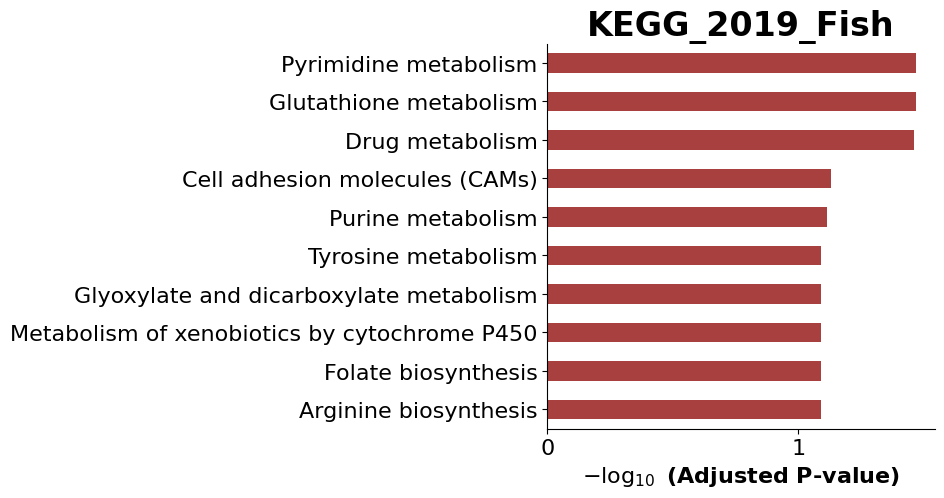

In [22]:
from gseapy import barplot, dotplot
import matplotlib.pyplot as plt
ax = barplot(full_res,title='KEGG_2019_Fish', figsize=(5, 5), color='darkred', cutoff=0.1)
plt.savefig(
    'dotplot/KEGG_barplot.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5,     # 更大的边距
    facecolor='white',
    edgecolor='none'
)

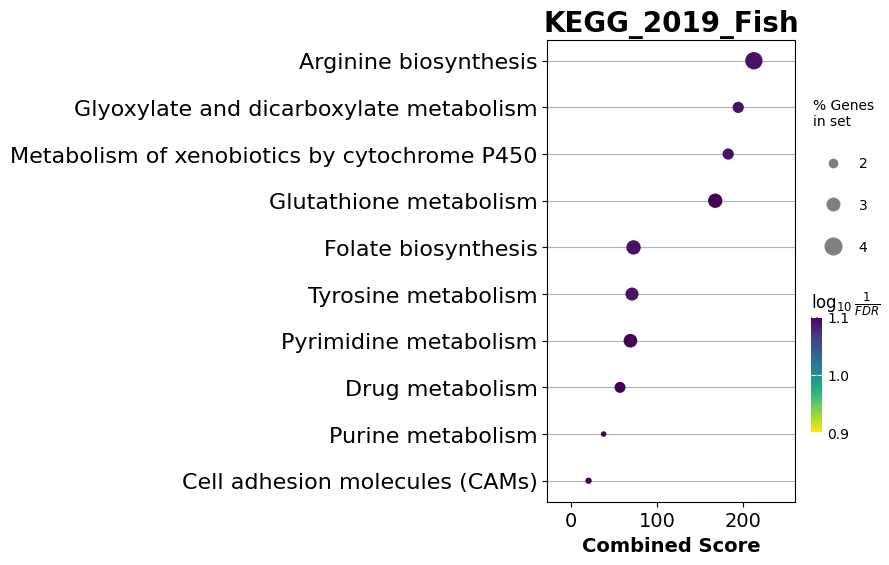

In [23]:
ax = dotplot(full_res, title='KEGG_2019_Fish',cmap='viridis_r', size=50, figsize=(4,6), cutoff=0.1)
plt.savefig(
    'dotplot/GO_dotplot.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.5,     # 更大的边距
    facecolor='white',
    edgecolor='none'
)


In [24]:
full_res.head(10)['Term']

3                           Glutathione metabolism
7                            Pyrimidine metabolism
8                                  Drug metabolism
13                  Cell adhesion molecules (CAMs)
10                               Purine metabolism
11          Nicotinate and nicotinamide metabolism
9                              Nitrogen metabolism
0                            Arginine biosynthesis
5                              Folate biosynthesis
2     Metabolism of xenobiotics by cytochrome P450
Name: Term, dtype: object